Let's use this as our model:
 - make some large number of donuts.
 - When doing this we sample two sets of data:
   - one drawn from the 'in focus' mesh plus misalignments
   - one drawn from a uniform random probability distribution in coords, rzeros, and zernikes
   
Then we'll either use some sort of gaussian process or nearest neighbors type deal to predict the moments.
WHEN DOING THE PREDICTIONS: YOU SHOULD NORMALIZE THE DISTRIBUTIONS.

When analyzing results where I look at zi, zj, and then a moment (or its interpolated prediction, or the error of the two), you need two sets of plots:
 - One where the zernikes are drawn from realistic distributions.
     - this tells you where in the zernike parameter space (or, x and y which are of course correlated) we will do poorly.
 - One where the zernikes are uniformly random with mean zero, std 1.0.
     - this one is much easier to interpret the behavior of the zernike polynomials, because if you plot the median, then you are averaging out all the other zernike contributions and recovering effectively the 2d distributions.
     
     
Maybe consider doing the fits for a fixed rzero, and then creating an overall scaling relationship with rzero? That is, rzero bleeds into e0 and e1 etc roughly linearly or 1/rzeroly

In [4]:
%matplotlib inline
from sklearn import cross_validation
import numpy as np
import os
import pandas as pd
from WavefrontPSF.decamutil import decaminfo
dec = decaminfo()

path = '/Users/cpd/Desktop/ComboMeshes-old/'
path_out = '/Users/cpd/Desktop/ComboMeshes2/'
mesh_name = 'Science-20140212s2-v1i2_All'#'Science-20121120s1-v1i2_All'
dTrains = []
dTests = []
dVals = []
fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
if os.path.exists(path_out + 'Mesh_' + mesh_name + '_val.dat'):
    
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    dTrains = pd.read_csv(trainName)
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    dTests = pd.read_csv(testName)
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    dVals = pd.read_csv(valName)

    
else:
    fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
    fileName = path + fileTitle + '.dat'
    dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),('z','float'),('w','float')])
    dTrain_base_indx, dTest_indx = cross_validation.train_test_split(np.arange(len(dataPoints)))
    # divide the dTrain_base_indx into dTrain_indx and dVal_indx
    dTrain_indx, dVal_indx = cross_validation.train_test_split(np.arange(len(dTrain_base_indx)))
    
    sensor = dataPoints['Sensor']
    # convert sensor to chip id
    x = dataPoints['x']
    y = dataPoints['y']
    
    columns = ['x', 'y', 'ccdnum']
    ccdnum = [dec.infoDict[sensor_i]['CCDNUM']
              for sensor_i in sensor]
    coords = np.array([x, y, ccdnum]).T
    dTests = coords[dTest_indx]
    dTrains = coords[dTrain_base_indx][dTrain_indx]
    dVals = coords[dTrain_base_indx][dVal_indx]
    for zi in range(4, 12):
        fileTitle = 'z{0}'.format(zi) + 'Mesh_' + mesh_name
        fileName = path + fileTitle + '.dat'
        zkey = 'z{0}'.format(zi)
        wkey = 'w{0}'.format(zi)
        columns += [zkey, wkey]
        
        dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),
                                                 (zkey, 'float'),(wkey,'float')])

        dTests = np.hstack((dTests,
                            dataPoints[zkey][dTest_indx][:, np.newaxis],
                            dataPoints[wkey][dTest_indx][:, np.newaxis]))
        dTrains = np.hstack((dTrains,
                            dataPoints[zkey][dTrain_base_indx][dTrain_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dTrain_indx][:, np.newaxis]))
        dVals = np.hstack((dVals,
                            dataPoints[zkey][dTrain_base_indx][dVal_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dVal_indx][:, np.newaxis]))
        # save!
        trainName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_train.dat'
        np.savetxt(trainName, dataPoints[dTrain_base_indx][dTrain_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        testName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_test.dat'
        np.savetxt(testName, dataPoints[dTest_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        valName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_val.dat'
        np.savetxt(valName, dataPoints[dTrain_base_indx][dVal_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])

    # save!
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    df = pd.DataFrame(dTrains, columns=columns)
    df.to_csv(trainName)
    dTrains = df
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    df = pd.DataFrame(dTests, columns=columns)
    df.to_csv(testName)
    dTests = df
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    df = pd.DataFrame(dVals, columns=columns)
    df.to_csv(valName)
    dVals = df

In [8]:
from WavefrontPSF.donutengine import DECAM_Model_Wavefront
WF = DECAM_Model_Wavefront(dTrains)
db_all = pd.read_csv('/Users/cpd/Desktop/donuts.csv')
# collect the deltas instead...
db_keys = ['dordodz', 'dordodx', 'dordody', 'dordoxt', 'dordoyt']
# db_keys = ['dorzdelta', 'dorz5delta', 'dorz6delta', 'dorz7delta', 'dorz8delta', 'dorz9delta', 'dorz10delta']
db = db_all[db_keys]
db['dordorzero'] = 0.5 * (db_all['dorrzeromedianintra'] + db_all['dorrzeromedianextra'])
db_keys += ['dordorzero']
# for key in db_keys:
#     db = db[db[key].notnull()]
#     db = db[np.abs(db[key]) < 500]
#     if key in ['dordodz', 'dordoxt', 'dordoyt']:
#         db = db[np.abs(db[key]) < 200]
for key in db_keys:
    db = db[db[key].notnull()]
    if key in ['dordodz', 'dordoxt', 'dordoyt']:
        db = db[np.abs(db[key]) < 200]
    elif key in ['dordodx', 'dordody']:
        db = db[np.abs(db[key]) < 500]
    else:
        db = db[np.abs(db[key]) < 0.75]
print(len(db))

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
22589


look at the database

KeyError: u'dordodx'

<function __main__.widget>

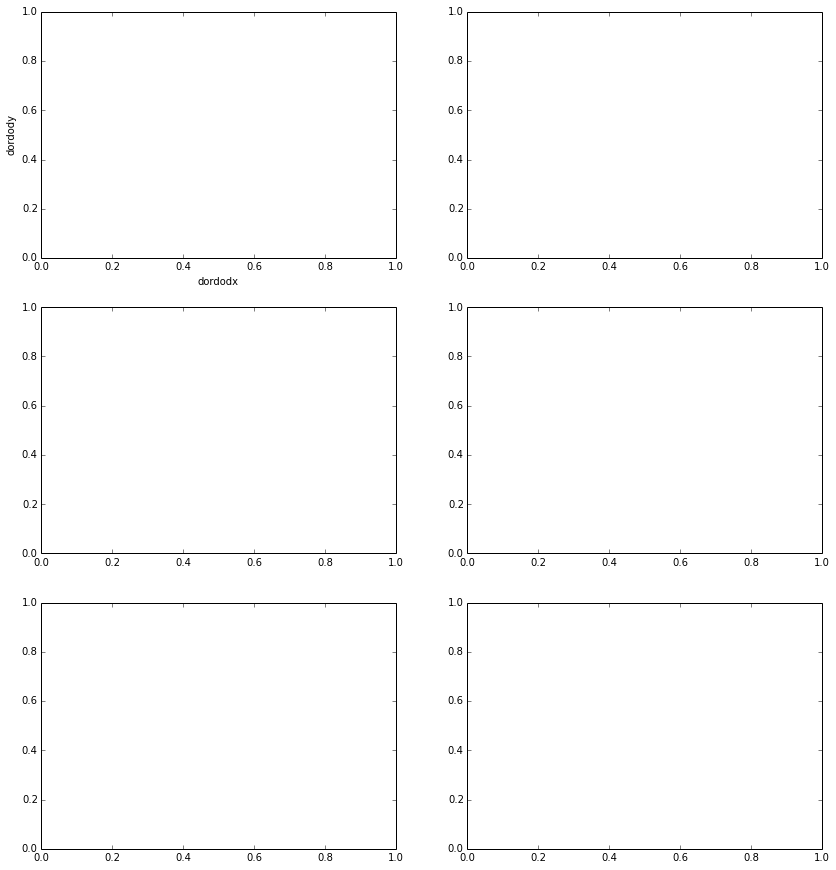

In [6]:
from WavefrontPSF.wavefront import shiftedColorMap

def plot_twod(xkey, ykey, zkey, data,
              reducer=np.median, num_bins=10,
              fig=None, ax=None):
    x = data[xkey]
    y = data[ykey]
    z = data[zkey]
    bins_x = np.linspace(np.min(x), np.max(x), num_bins)
    bins_y = np.linspace(np.min(y), np.max(y), num_bins)
    groups = data.groupby([pd.cut(x, bins_x), pd.cut(y, bins_y)])
    field = groups.aggregate(reducer)
    # filter out nanmins on x and y
    field = field[field[xkey].notnull() &
                  field[ykey].notnull() &
                  field[zkey].notnull()]
    zfield = field[zkey][field[zkey].notnull()]
    
    indx_x = field.index.labels[0].values()
    indx_y = field.index.labels[1].values()
    # here is something that is going to be irritating and cludgey:
    # let's get the values of the different bins (for sorting purposes)
    x_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in field.index.levels[0]])
    y_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in field.index.levels[1]])
    # now sort the order for the levels
    x_vals_argsorted = np.argsort(x_vals)
    y_vals_argsorted = np.argsort(y_vals)
    # now this means that the 0th entry in x_vals_argsorted comes first
    # so we want indx_x_transform to represent the sorted values
    # so instead of indx_x representing arbitrary bin i, we want it to
    # instead represent sorted bin j
    indx_x_transform = np.argsort(np.arange(len(x_vals))[np.argsort(x_vals)])[indx_x]
    indx_y_transform = np.argsort(np.arange(len(y_vals))[np.argsort(y_vals)])[indx_y]

    if ax == None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax.set_xlabel(xkey)
        ax.set_ylabel(ykey)

    # figure out shifting the colormap
    b = np.max(zfield)
    a = np.min(zfield)
    c = 0
    midpoint = (c - a) / (b - a)
    if midpoint <= 0:
        cmap = plt.cm.Reds
    else:
        cmap = shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint)
    vmin = a
    vmax = b

    C = np.ma.zeros((indx_x.max() + 1, indx_y.max() + 1))
    C.mask = np.ones((indx_x.max() + 1, indx_y.max() + 1))
    np.add.at(C, [indx_x_transform, indx_y_transform],
              zfield.values)
    np.multiply.at(C.mask, [indx_x_transform, indx_y_transform], 0)
    # bloops
    C = C.T

    IM = ax.pcolor(bins_x, bins_y, C,
                   cmap=cmap, vmin=vmin, vmax=vmax)
    CB = fig.colorbar(IM, ax=ax)
    CB.ax.set_ylabel(zkey, rotation=270)
    
#     # look at scatter plots
#     ax = axes[1]
#     ax.set_xlabel(xkey)
#     ax.set_ylabel(zkey)
#     IM = ax.scatter(x, z, marker='o', c=y, cmap=plt.cm.RdBu_r, linewidth=0.5, alpha=0.5)
#     CB = fig.colorbar(IM, ax=ax)
#     CB.ax.set_ylabel(ykey, rotation=270)

#     ax = axes[2]
#     ax.set_xlabel(ykey)
#     ax.set_ylabel(zkey)
#     IM = ax.scatter(y, z, marker='o', c=x, cmap=plt.cm.RdBu_r, linewidth=0.5, alpha=0.5)
#     CB = fig.colorbar(IM, ax=ax)
#     CB.ax.set_ylabel(xkey, rotation=270)

    return fig, ax

def plot_combo_2d(xkey, ykey, zkey, data,
                  reducer=np.median, num_bins=10,
                  fig=None, ax=None):
    
    if ax == None:
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7 * 2, 5 * 3))
        
        
    ax = axes[0,0]
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    fig, ax = plot_twod(xkey, ykey, zkey, data,
              reducer=reducer, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[1,0]
    ax.set_xlabel(xkey)
    ax.set_ylabel(zkey)
    fig, ax = plot_twod(xkey, zkey, ykey, data,
              reducer=reducer, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[2,0]
    ax.set_xlabel(ykey)
    ax.set_ylabel(zkey)
    fig, ax = plot_twod(ykey, zkey, xkey, data,
              reducer=reducer, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[0,1]
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    fig, ax = plot_twod(xkey, ykey, zkey, data,
              reducer=len, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[1,1]
    ax.set_xlabel(xkey)
    ax.set_ylabel(zkey)
    fig, ax = plot_twod(xkey, zkey, ykey, data,
              reducer=len, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[2,1]
    ax.set_xlabel(ykey)
    ax.set_ylabel(zkey)
    fig, ax = plot_twod(ykey, zkey, xkey, data,
              reducer=len, num_bins=num_bins,
              fig=fig, ax=ax)
    
    return fig, axes

from IPython.html.widgets import interact
from IPython.html import widgets
def widget(xkey, ykey, zkey):
    plot_combo_2d('dordo' + xkey, 'dordo' + ykey, 'dordo' + zkey, db,
                  num_bins=25)
    return
interact(widget,
         xkey='dx',
         ykey='dy',
         zkey='rzero')

huh, dy, yt, and rzero are correlated.

In [4]:
# TODO: This is extremely slow?!
def apply_misalignments(data, wf=WF):
    misalign_keys = ['dordodz', 'dordodx', 'dordody', 'dordoxt', 'dordoyt']
    for index, zernike in data.iterrows():
        x = zernike['x']
        y = zernike['y']
        
        misalign_dict = {}
        for key in misalign_keys:
            misalign_dict[key] = zernike[key]
        misalign_dict['rzero'] = zernike['dordorzero']
        misalignment = wf.misalign_optics(misalign_dict)
        
        for z in xrange(4, 9):
            key = 'z{0}'.format(z)
            if z != 4:
                correction = misalignment[key + 'd'] + \
                             misalignment[key + 'y'] * x + \
                             misalignment[key + 'x'] * y
            else:
                # z4 needs to be in waves, too!
                numfac = 0.0048481  # rad / arcsec um/mm
                wavefac = 172.  # waves / mm
                correction = misalignment[key + 'd'] + \
                             misalignment[key + 'y'] * x * numfac + \
                             misalignment[key + 'x'] * y * numfac
            if key not in data:
                data.iloc[index][key] = correction
            else:
                data.iloc[index][key] += correction
            if z == 4:
                data.iloc[index][key] /= wavefac
    return data

In [86]:
def evaluate_zernikes(data, wf=WF):
    # make the donut!
    stamps = []
    for index, zernike in data.iterrows():
        xi = zernike['x']
        yi = zernike['y']
        inputZernikeArray = np.array([zernike['z{0}'.format(i)]
                                      for i in xrange(1, 12)])
        rzero = zernike['rzero']
        stamp = wf.draw_donut(xi, yi, inputZernikeArray, rzero)
        stamps.append(stamp)
    stamps = np.array(stamps)
    psf_keys = ['e0', 'e1', 'e2', 'delta1', 'delta2', 'zeta1', 'zeta2',
                    'a4', 'flux', 'Mx', 'My']
    evaluated_psfs = wf.PSF_Evaluator(stamps)
    evaluated_psfs.index = data.index
    data = pd.concat([data, evaluated_psfs[psf_keys]], axis=1)
    return data, stamps

data = dVals.copy()#.iloc[np.random.choice(len(dVals), size=1000)]
# add the other keys -- z1, z2, z3
data['z1'] = 0
data['z2'] = 0
data['z3'] = 0
# apply misalignments
db_random = db.iloc[np.random.choice(len(db), size=len(data))]
db_random.index = data.index
data['rzero'] = db_random['dordorzero']
data['z4'] = (data['z4'] - db_random['dorzdelta']) / 172.  # now in waves!
for zi in range(5, 11):
    key_data = 'z{0}'.format(zi)
    key_db = 'dorz{0}delta'.format(zi)
    data[key_data] -= db_random[key_db]

data, stamps = evaluate_zernikes(data)

In [87]:
# now using the data, interpolate to the test set
dTests_kNN = dTests.copy()#.iloc[np.random.choice(len(dTests), size=1000)]
# set it up
# add the other keys -- z1, z2, z3
dTests_kNN['z1'] = 0
dTests_kNN['z2'] = 0
dTests_kNN['z3'] = 0
# fix z4
dTests_kNN['z4'] /= 172.
# add rzero
db_random_kNN = db.iloc[np.random.choice(len(db), size=len(dTests_kNN))]
db_random_kNN.index = dTests_kNN.index
dTests_kNN['rzero'] = db_random_kNN['dordorzero']
dTests_kNN, stamps_kNN = evaluate_zernikes(dTests_kNN)


In [90]:
# np.save('/Users/cpd/Desktop/dTests_kNN_Stamps', stamps)
# dTests_kNN.to_csv('/Users/cpd/Desktop/dTests_kNN.csv')
# data.to_csv('/Users/cpd/Desktop/dVals.csv')

In [127]:
from WavefrontPSF_new.psf_interpolator import kNN_Interpolator
y_keys = ['e0', 'e1', 'e2', 'zeta1', 'zeta2', 'delta1', 'delta2']
x_keys = ['z{0}'.format(i) for i in range(4, 12)] + ['rzero'] #+ ['x', 'y']

interpolator = kNN_Interpolator(data, y_keys=y_keys, x_keys=x_keys)
# now interpolate!
dTests_kNN_interp = interpolator.interpolate(dTests_kNN)

# evaluate!
truth = dTests_kNN[y_keys]
guess = dTests_kNN_interp
for key in y_keys:
    guess[key + '_error'] = truth[key] - guess[key]
    guess[key + '_truth'] = truth[key]
if 'x' not in guess:
    guess['x'] = dTests_kNN['x']
    guess['y'] = dTests_kNN['y']

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


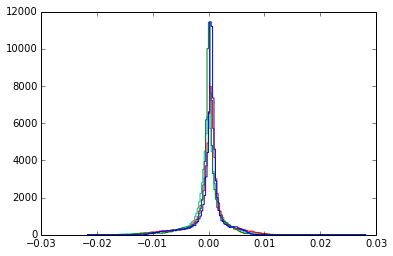

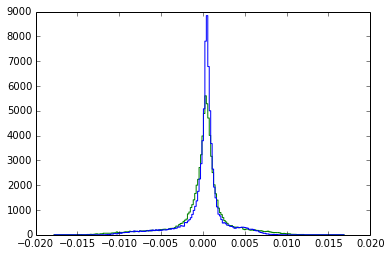

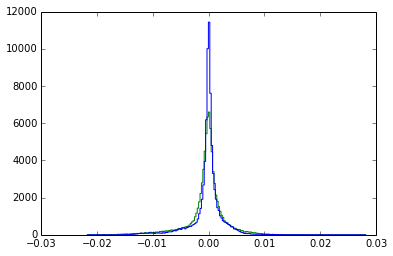

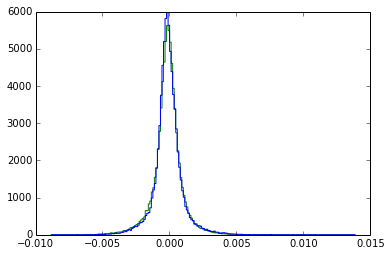

In [128]:
plt.figure()
plt.hist([guess['e1'], guess['e2'], guess['e1_truth'], guess['e2_truth']], histtype='step', bins=200);
plt.figure()
plt.hist([guess['e1'], guess['e1_truth']], histtype='step', bins=200);
plt.figure()
plt.hist([guess['e2'], guess['e2_truth']], histtype='step', bins=200);
plt.figure()
plt.hist([guess['e1_error'], guess['e2_error']], histtype='step', bins=200);

In [142]:
print(np.std(guess['e1_error']), np.std(guess['e2_error']))
print(np.mean(guess['e1_error']), np.mean(guess['e2_error']))

print(np.std(guess['e1_truth']), np.std(guess['e2_truth']))
print(np.mean(guess['e1_truth']), np.mean(guess['e2_truth']))

0.00104235227204 0.00109105385139
-9.34059014533e-05 -0.000140822978958
0.00314771056595 0.00339676244861
5.8004323879e-05 -0.000328793608018


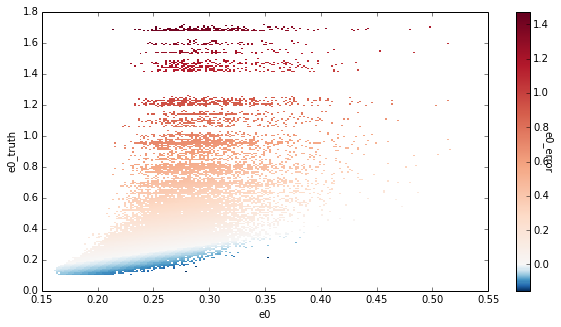

In [144]:
def interpwidget(key):
    plot_twod(key, key + '_truth', key + '_error', guess, reducer=np.mean, num_bins=200)
    
interact(interpwidget,
         key=y_keys);

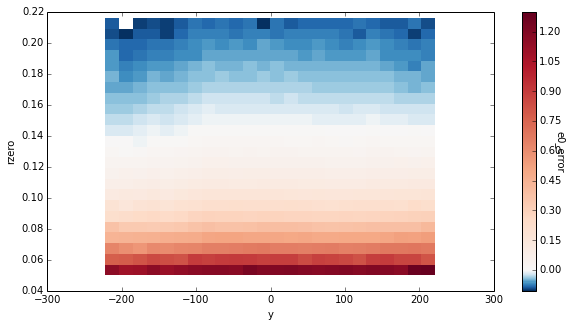

In [191]:
def interpwidget(xkey, ykey, zkey, ztype):
    plot_twod(xkey, ykey, zkey + ztype, guess, reducer=np.median, num_bins=25)
    
interact(interpwidget,
         xkey = ['z{0}'.format(i) for i in range(4, 12)] + ['rzero'] + ['x', 'y'],
         ykey = ['z{0}'.format(i) for i in range(4, 12)] + ['rzero'] + ['x', 'y'],
         zkey = ['e0', 'e1', 'e2', 'zeta1', 'zeta2', 'delta1', 'delta2'],
         ztype = ['_truth', '_error', '']
        );

x        -162.349500
y        -123.577500
rzero       0.096171
flux        0.459075
Mx         16.244843
My         16.170435
e0          0.499214
e1         -0.004576
e2          0.019177
zeta1       0.001183
zeta2       0.001023
delta1     -0.001236
delta2      0.001117
Name: 12, dtype: float64


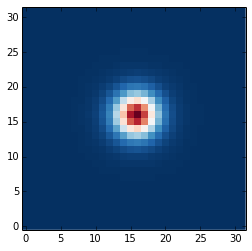

In [138]:
from IPython.html.widgets import interact
def plotstamp(zi):
    plt.imshow(stamps[zi])
    keys = ['x', 'y', 'rzero', 'flux', 'Mx', 'My', 'e0', 'e1', 'e2', 'zeta1', 'zeta2', 'delta1', 'delta2']
    print(data.iloc[zi][keys])
    return
interact(plotstamp,
         zi=(0,len(data) - 1))

In [ ]:
# # donuts from in focus mesh
# from WavefrontPSF_new.donutengine import DECAM_Model_Wavefront
# WF = DECAM_Model_Wavefront(dTrains)
# WF.data = pd.read_csv('/Users/cpd/Desktop/data.csv')
# WF.cutouts = np.load('/Users/cpd/Desktop/data_cutouts.npy')
# # _ = WF.get_psf_stats(dVals['x'], dVals['y'])
# # WF.data.to_csv('/Users/cpd/Desktop/data_vals.csv')
# # np.save('/Users/cpd/Desktop/data_cutouts_vals', WF.cutouts)